# A workflow for analyzing Craigslist Text using LDA

In [62]:
"""Import Modules"""
import preprocess
from datetime import datetime
import lda_output
import pandas as pd
import numpy as np
import logging
import cl_census
from gensim import corpora, models, similarities, matutils

In [63]:
"""Start Logging"""
# Some of the code below takes a long time to run, the logging helps knwo that it's still working
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [64]:
"""Import text as DataFrame"""
# this is a preprocessed file of around 40,000 CL texts
data_path = 'data/processed4_22.csv'
df = pd.read_csv(data_path, index_col=0,dtype = {'GEOID10':object,'blockid':object})


In [65]:
"""Make New Demo Columns"""
# this is based on the census vars I downloaded
prop_list = ['white','black','aindian','asian','pacisland','other','latinx']
df['poverty_proportion'] = df.under_poverty/df.total_poverty
# making census vars into proportions
for proportion in prop_list:
    df[proportion+'_proportion'] = df[proportion]/df.total_RE

In [66]:
"""Make Stratifying Columns"""
strat_list = []
new_col_list = []
# make a list of new col names
for proportion in prop_list:
    strat_list.append(proportion+'_proportion')
    new_col_list.append('high_'+proportion)
#make some stratifing columns
df = preprocess.make_stratifier(df, 'income', 'high_income')
df = preprocess.make_stratifier(df, strat_list, new_col_list)

In [67]:
"""Make Categorical Race_Income Variable"""
#starts as high_white
df['race_income'] = df.high_white
#adjust to include income
df = df.assign(race_income =  np.where(df.high_income==1, df.race_income+2, df.race_income))
#add text lables 
labels = {3:"high income and high white", 2:"high income low white", 1:"low income high white", 0:"low income low white"}
df['race_income_label'] = [labels[x] for x in df.race_income]
df[['race_income', 'race_income_label']]
#check to make sure it worked
pd.crosstab(df.race_income_label, [df.high_income, df.high_white])

high_income                    0           1      
high_white                     0     1     0     1
race_income_label                                 
high income and high white     0     0     0  5857
high income low white          0     0  3920     0
low income high white          0  3894     0     0
low income low white        6579     0     0     0

# Model And Output
From here, we'll work through making a corpus and dictionary, fitting an LDA model, interpreting the results various ways, and then outuptting some info in a readable format. I'd love feedback on this part of the workflow especially :).

Also, it talkes a long time to fit an LDA model, but if you pulled my GIT, you should have some saved models in the models folder. I've commented out the lines that run the model below and commented *in* the lines which load a model that's already been fit to the data loaded above.

*the cell below takes some time to run*

In [68]:
"""Make Corpus and Dictionary"""
with open('resources/hoods.txt') as f:
    neighborhoods = f.read().splitlines()
from sklearn.feature_extraction import stop_words
hood_stopwords = neighborhoods + list(stop_words.ENGLISH_STOP_WORDS)
corpus, dictionary = preprocess.df_to_corpus([str(x) for x in df.clean_text], stopwords=hood_stopwords)

2018-04-25 16:07:43,357 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-25 16:07:44,649 : INFO : adding document #10000 to Dictionary(28823 unique tokens: ['!', '$', 'available', 'bath', 'bedroom']...)
2018-04-25 16:07:46,096 : INFO : adding document #20000 to Dictionary(60926 unique tokens: ['!', '$', 'available', 'bath', 'bedroom']...)
2018-04-25 16:07:46,135 : INFO : built Dictionary(61885 unique tokens: ['!', '$', 'available', 'bath', 'bedroom']...) from 20250 documents (total 2689227 corpus positions)


In [69]:
"""Run Lda Model"""
n_topics = 50
n_passes = 50
# Run this if you have access to more than one core set workers=n_cores-1 
# this takes more than an hour on my mac, so if you just wnat to mess around, load the model in the cell below
#model = models.ldamulticore.LdaMulticore(corpus, id2word = dictionary, num_topics=n_topics, passes = n_passes, iterations = 100, minimum_probability=0, workers=3)
# otherwise run this
#model = models.LdaModel(corpus, id2word = dictionary, num_topics=n_topics, passes = n_passes, iterations = 100, minimum_probability=0)
# save the model for future use
#now = datetime.now()
#model.save('models/model'+str(now.month)+'_'+str(now.day))


In [70]:
"""Load an Premade Model"""
model = models.LdaModel.load('models/model4_23')

2018-04-25 16:34:38,700 : INFO : loading LdaModel object from models/model4_23
2018-04-25 16:34:38,717 : INFO : loading expElogbeta from models/model4_23.expElogbeta.npy with mmap=None
2018-04-25 16:34:38,768 : INFO : setting ignored attribute dispatcher to None
2018-04-25 16:34:38,771 : INFO : setting ignored attribute id2word to None
2018-04-25 16:34:38,775 : INFO : setting ignored attribute state to None
2018-04-25 16:34:38,779 : INFO : loaded models/model4_23
2018-04-25 16:34:38,782 : INFO : loading LdaState object from models/model4_23.state
2018-04-25 16:34:38,883 : INFO : loaded models/model4_23.state


*the cell below takes some time to run*

In [71]:
"""Merge LDA output and DF"""
#Make LDA corpus of our Data
lda_corpus = model[corpus]
#make dense numpy array of the topic proportions for each document
doc_topic_matrix = matutils.corpus2dense(lda_corpus, num_terms=n_topics).transpose()
df = df.reset_index(drop=True).join(pd.DataFrame(doc_topic_matrix))

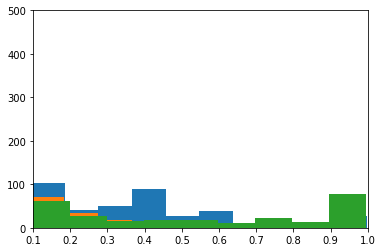

In [72]:
"""Look at the distributions of the different topics"""
#you can mess with this if you want to look at different topic histograms
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df[[26]].sort_values(by=26, ascending=False).head(400).values)
plt.hist(df.groupby('GEOID10').mean()[[4]].dropna().values)
df.columns
df.groupby('race_income_label').mean()[26]
plt.hist(df[df.race_income==0][41].values)
plt.axis([.1, 1, 0, 500])
weights = df[list(range(50))].mean()

# Using stratifiers to organize the LDA output
The next section here explores various ways to sort the data. Which of these seems most useful?

In [75]:
"""Use stratifier to create various comparisions of topic distributions"""
#strat_col = 'high_income'
# sorted_values = lda_output.compare_topics_distribution(df, n_topics, strat_col)
# Uncomment one of these to sort the Text output differently
#sorted_values = lda_output.summarize_on_stratifier(df, n_topics, strat_col)
#sorted_values = mean_diff.sort_values('difference', ascending=False)

'Use stratifier to create various comparisions of topic distributions'

In [76]:
"""Try a Multinomial LogisticRegression"""
from sklearn.linear_model import LogisticRegression

X = df.dropna()[list(range(50))]
y = df.dropna().race_income_label
y_highwhite = df.dropna().high_white
LR = LogisticRegression()
LR.fit(X,y)
# high_white_LR = LR.fit(X,y_highwhite)
# high_white_LR.score(X,y_highwhite)
# highwhite_coefs = pd.DataFrame(LR.coef_).rename(labels).transpose()
lr_coefs = pd.DataFrame(LR.coef_).rename(dict(zip(range(4),LR.classes_))).transpose()
lr_coefs['summed_diff'] = abs((lr_coefs['low income low white']-lr_coefs['low income high white']) + (lr_coefs['high income low white']-lr_coefs['high income and high white']))
#sorted_values = lr_coefs.sort_values('summed_diff', ascending=False)

In [83]:
"""Make Predictions at the means"""
# Use this to set the value that each topic probability will take to make predictions
test_value = .75
# calculate the mean of each topic to use for weighting below
weights = df[list(range(n_topics))].mean()
test = np.full((50,50), 1-test_value)
for i in range(50):
    test[i,] = test[i,]*weights
    #this makes other values take a proportion of 1-test weighted by their mean proportion
    test[i,i] = test_value + test[i,i]*weights[i]
#rename according to LR.classes_
predicted_proba = pd.DataFrame(LR.predict_proba(test)).rename(dict(zip(range(4),LR.classes_)), axis = 1)
# also calculate category predictions (I use this to make sure that the highes prob label is getting predicted)
predictions =  pd.DataFrame(LR.predict(test))
# takes the difference between the racial categories in each income category and then sums thoes differences
# the idea is to sort the topics by how well they differentiate high and low white neighborhoods when controlling
# for income
predicted_proba['summed_diff'] = abs((predicted_proba['low income low white']-predicted_proba['low income high white']) + (predicted_proba['high income low white']-predicted_proba['high income and high white']))
predicted_proba.sort_values('summed_diff', ascending=False).head(10)


,high income and high white,high income low white,low income high white,low income low white,summed_diff
41,0.068665,0.368432,0.061364,0.501539,0.739942
26,0.394361,0.017472,0.456437,0.131730,0.701596
20,0.183781,0.102808,0.657674,0.055737,0.682911
9,0.421538,0.041831,0.418934,0.117696,0.680946
38,0.322545,0.047028,0.508344,0.122083,0.661779
33,0.169694,0.090928,0.643110,0.096269,0.625607
34,0.741147,0.123313,0.060060,0.075479,0.602415
13,0.641645,0.039152,0.144548,0.174655,0.572385
11,0.073715,0.115493,0.141853,0.668939,0.568864
49,0.233893,0.259768,0.014909,0.491431,0.502397


# Finally: Output
This final cell uses one version of the ordered topics from above to create organized output of the models, their distribution across our stratifier (race_income_labeled), and example texts

In [80]:
"""Produces useful output of topics and example texts"""
# decide how you want to sort the topics, I'm using the predicted probabilities from above
# Uncomment one of these to sort the Text output differently
#sorted_values = lda_output.summarize_on_stratifier(df, n_topics, strat_col)
#sorted_values = mean_diff.sort_values('difference', ascending=False)
#sorted_values = lr_coefs.sort_values('summed_diff', ascending=False)
sorted_values = predicted_proba.sort_values('summed_diff', ascending=False)
now = datetime.now()
reload(lda_output)
lda_output.text_output(df, 
                       text_col='body_text', 
                       filepath='output/cl'+str(now.month)+'_'+str(now.day)+'.txt', 
                       model= model, 
                       sorted_topics=sorted_values, 
                       strat_col='race_income_label', 
                       #set to False to save to file
                       print_it = True,
                       cl=True)


2018-04-25 16:40:51,818 : INFO : Automatically generating topic list
2018-04-25 16:40:51,858 : INFO : topic #0 (0.020): 0.024*"apartments" + 0.011*"bedroom" + 0.010*"floor" + 0.009*"apartment" + 0.008*"!" + 0.007*"enjoy" + 0.007*"available" + 0.007*"make" + 0.007*"living" + 0.006*"parking" + 0.006*"features" + 0.006*"modern" + 0.006*"wildreed" + 0.006*"kitchen" + 0.006*"amenities" + 0.006*"rooftop" + 0.006*"url" + 0.005*"high" + 0.005*"plans" + 0.005*"deck"
2018-04-25 16:40:51,860 : INFO : topic #1 (0.020): 0.092*"â" + 0.024*"contact" + 0.012*"url" + 0.011*"!" + 0.011*"infox" + 0.011*"$" + 0.007*"available" + 0.007*"availability" + 0.006*"lease" + 0.006*"wa" + 0.006*"fitness" + 0.006*"today" + 0.005*"access" + 0.005*"pool" + 0.005*"center" + 0.004*"resident" + 0.004*"date" + 0.004*"lounge" + 0.004*"movein" + 0.004*"outdoor"
2018-04-25 16:40:51,867 : INFO : topic #2 (0.020): 0.040*"green" + 0.032*"lake" + 0.013*"energy" + 0.012*"circa" + 0.011*"natural" + 0.010*"youll" + 0.010*"access" 

2018-04-25 16:40:51,945 : INFO : topic #22 (0.020): 0.012*"community" + 0.011*"ave" + 0.009*"th" + 0.008*"n" + 0.008*"anne" + 0.008*"queen" + 0.007*"access" + 0.007*"url" + 0.007*"center" + 0.007*"park" + 0.006*"pet" + 0.006*"street" + 0.006*"ne" + 0.006*"available" + 0.006*"storage" + 0.006*"bike" + 0.005*"parking" + 0.005*"amenities" + 0.005*"apartment" + 0.005*"maintenance"
2018-04-25 16:40:51,947 : INFO : topic #23 (0.020): 0.015*"!" + 0.007*"center" + 0.007*"home" + 0.007*"community" + 0.007*"url" + 0.006*"apartment" + 0.006*"new" + 0.006*"package" + 0.006*"steel" + 0.006*"fitness" + 0.006*"stainless" + 0.006*"bedroom" + 0.006*"sq" + 0.006*"service" + 0.006*"access" + 0.006*"room" + 0.005*"flooring" + 0.005*"timbers" + 0.005*"office" + 0.005*"approximately"
2018-04-25 16:40:51,949 : INFO : topic #24 (0.020): 0.017*"home" + 0.014*"bedrooms" + 0.013*"lake" + 0.012*"bedroom" + 0.011*"apartment" + 0.011*"homes" + 0.011*"hills" + 0.010*"center" + 0.010*"shopping" + 0.009*"town" + 0.009

2018-04-25 16:40:51,992 : INFO : topic #44 (0.020): 0.014*"contact" + 0.014*"home" + 0.013*"community" + 0.013*"credit" + 0.011*"complete" + 0.008*"touring" + 0.008*"changeequal" + 0.008*"practice" + 0.008*"outdoor" + 0.008*"pool" + 0.007*"available" + 0.007*"access" + 0.007*"court" + 0.007*"shopping" + 0.007*"pet" + 0.007*"provide" + 0.007*"craigslist" + 0.007*"require" + 0.007*"application" + 0.007*"term"
2018-04-25 16:40:51,995 : INFO : topic #45 (0.020): 0.012*"center" + 0.009*"community" + 0.009*"storage" + 0.008*"lounge" + 0.008*"!" + 0.008*"room" + 0.008*"pet" + 0.007*"$" + 0.007*"kitchen" + 0.006*"bedroom" + 0.006*"fitness" + 0.006*"url" + 0.005*"views" + 0.005*"dog" + 0.005*"area" + 0.005*"appliances" + 0.005*"business" + 0.005*"available" + 0.005*"amenities" + 0.005*"garage"
2018-04-25 16:40:51,999 : INFO : topic #46 (0.020): 0.021*"access" + 0.017*"community" + 0.017*"managed" + 0.013*"url" + 0.013*"parking" + 0.012*"features" + 0.012*"private" + 0.011*"lounge" + 0.010*"wa" 

Topic # 41  occurred in 
 high income and high white    0.068665
high income low white         0.368432
low income high white         0.061364
low income low white          0.501539
summed_diff                   0.739942
Name: 41, dtype: float64 
 Top keywords are: home, pet, park, access, bedroom, pets, center, url, welcome, washer, dryer, internet, apartment, wa, housing, state, restrictions, breed, sq
Topic # 26  occurred in 
 high income and high white    0.394361
high income low white         0.017472
low income high white         0.456437
low income low white          0.131730
summed_diff                   0.701596
Name: 26, dtype: float64 
 Top keywords are: animal, city, bedroom, months, animals, home, contact, office, community, just, dogs, bath, pm, property, views, terriers, fee, apartment
Topic # 20  occurred in 
 high income and high white    0.183781
high income low white         0.102808
low income high white         0.657674
low income low white          0.055737
summed

2018-04-25 16:40:52,357 : INFO : Completed Output



 Top keywords are: room, community, apartment, pet, living, apartments, vintage, homes, amenities, bedroom, luxury, wa, home, center, located, youll, social, spacious
Topic # 30  occurred in 
 high income and high white    0.259229
high income low white         0.086704
low income high white         0.106438
low income low white          0.547629
summed_diff                   0.268666
Name: 30, dtype: float64 
 Top keywords are: apartments, bedroom, home, modern, rent, large, floor, kitchens, alaire, contact, parking, include, available, designer, living, center, subject, select, area, amenities
Topic # 44  occurred in 
 high income and high white    0.187177
high income low white         0.062080
low income high white         0.179775
low income low white          0.570967
summed_diff                   0.266095
Name: 44, dtype: float64 
 Top keywords are: contact, home, community, credit, complete, touring, changeequal, practice, outdoor, pool, available, access, court, shopping, pet